In [13]:
import os
import pandas as pd
import numpy as np
from scipy.integrate import trapz

In [14]:
# Constants
FLOW_RATE = 400  # mL/min
T_N = 23.32258   # Reference temperature for Q10 correction
DATA_DIR = r"D:\Respirometry\Bumblebee\flying"
META_PATH = r"C:\Users\labadmin\Documents\Uppsala analyses\beeID laser file name + weight.xlsx"

In [15]:
# Load metadata
bee_meta = pd.read_excel(META_PATH, sheet_name="flying_bees")
bee_meta["BeeID"] = bee_meta["BeeID"].astype(str).str.strip().str.lower()

In [18]:
results = []

# Process ALL files, even without extensions
for fname in os.listdir(DATA_DIR):
    file_path = os.path.join(DATA_DIR, fname)

    if not os.path.isfile(file_path):
        continue

    print(f"\n📂 Attempting file: {fname}")

    # Try loading without extension assumption
    try:
        df = pd.read_csv(file_path, sep="\t", engine="python")
        print("✅ File loaded with tab separator.")
    except Exception:
        try:
            df = pd.read_csv(file_path, sep=",", engine="python")
            print("✅ File loaded with comma separator.")
        except Exception as e:
            print(f"❌ Failed to read file: {e}")
            continue

    # Check columns
    required_cols = {'CO2', 'O2s', 'Seconds', 'Marker'}
    if not required_cols.issubset(df.columns):
        print(f"❌ Missing columns: {required_cols - set(df.columns)}")
        continue

    # Extract BeeID
    parts = fname.split("_")
    if len(parts) < 4:
        print("❌ Could not extract BeeID from filename.")
        continue

    bee_id = parts[3].strip().lower()
    print(f"🔍 Extracted BeeID: '{bee_id}'")

    # Match BeeID in metadata
    match = bee_meta[bee_meta["BeeID"].str.contains(bee_id, na=False)]
    if match.empty:
        print(f"❌ No metadata match for BeeID '{bee_id}'")
        continue

    T_a = match["Temperature"].values[0]
    if pd.isna(T_a):
        print("❌ Missing temperature in metadata.")
        continue

    # Markers
    marker_idxs = df.index[df["Marker"] == 100].tolist()
    if len(marker_idxs) < 2:
        print("❌ Not enough marker 100 entries.")
        continue

    start_idx, end_idx = marker_idxs[0], marker_idxs[1]
    window = df.iloc[start_idx:end_idx+1].copy()

    if len(window) < 2:
        print("❌ Not enough data points between markers.")
        continue

    # Convert to ppm
    window["CO2_ppm"] = np.abs(window["CO2"]) * 1e4
    window["O2_ppm"] = np.abs(window["O2s"]) * 1e4

    t = window["Seconds"].values
    co2 = window["CO2_ppm"].values
    o2 = window["O2_ppm"].values
    dt = t[-1] - t[0]

    if dt <= 0:
        print("❌ Invalid time range (dt <= 0).")
        continue

    # Q10 adjustment
    q10 = 10 ** ((T_N - T_a) * (np.log10(2) / 10))
    area_co2 = trapz(co2, t)
    area_o2 = trapz(o2, t)

    co2_rate_uL_h = (((area_co2 * q10 / 1e6 * FLOW_RATE) / 60) / dt) * 3600 * 1e3
    o2_rate_uL_h = (((area_o2 * q10 / 1e6 * FLOW_RATE) / 60) / dt) * 3600 * 1e3
    rq = co2_rate_uL_h / o2_rate_uL_h if o2_rate_uL_h != 0 else np.nan

    results.append({
        "BeeID": bee_id,
        "ColonyID": colony_id,
        "Filename": fname,
        "dt_sec": dt,
        "Temperature": T_a,
        "q10": q10,
        "CO2_rate_uL_h_raw": co2_rate_uL_h,
        "O2_rate_uL_h_raw": o2_rate_uL_h,
        "RQ_raw": rq
    })

    print(f"✅ Success: RQ = {rq:.3f}")


📂 Attempting file: Data_03-10-2025_001_red31_flower_corrected_secfromstart
✅ File loaded with tab separator.
🔍 Extracted BeeID: 'red31'
✅ Success: RQ = 0.848

📂 Attempting file: Data_03-10-2025_001_unmarked33_flower_corrected_secfromstart
✅ File loaded with tab separator.
🔍 Extracted BeeID: 'unmarked33'
✅ Success: RQ = 0.750

📂 Attempting file: Data_03-10-2025_001_unmarked34_flower_corrected_secfromstart
✅ File loaded with tab separator.
🔍 Extracted BeeID: 'unmarked34'
✅ Success: RQ = 0.896

📂 Attempting file: Data_03-10-2025_001_unmarked3_flower_corrected_secfromstart
✅ File loaded with tab separator.
🔍 Extracted BeeID: 'unmarked3'
✅ Success: RQ = 1.026

📂 Attempting file: Data_03-11-2025_001_green3_flower_corrected_secfromstart
✅ File loaded with tab separator.
🔍 Extracted BeeID: 'green3'
✅ Success: RQ = 0.962

📂 Attempting file: Data_03-11-2025_001_unmarked38_flower_corrected_secfromstart
✅ File loaded with tab separator.
🔍 Extracted BeeID: 'unmarked38'
✅ Success: RQ = 1.006

📂 Att

In [19]:
# Display results
results_df = pd.DataFrame(results)
if results_df.empty:
    print("\n⚠️ Final Result: Still no data processed. But file loading is fixed — check individual file logs.")
else:
    results_df = results_df.sort_values("BeeID")
    print("\n✅ Final processed DataFrame:")
    display(results_df)


✅ Final processed DataFrame:


,BeeID,Filename,dt_sec,Temperature,q10,CO2_rate_uL_h_raw,O2_rate_uL_h_raw,RQ_raw
4,green3,Data_03-11-2025_001_green3_flower_corrected_se...,292,23.5,0.987777,10208.211810,10612.439263,0.961910
8,green4,Data_03-20-2025_001_green4_flower_corrected_se...,293,23.5,0.987777,13998.919397,15836.906849,0.883943
18,green5,Data_23-03-2025_001_green5_flower_corrected_se...,361,24.0,0.954130,14381.278160,13586.014497,1.058535
0,red31,Data_03-10-2025_001_red31_flower_corrected_sec...,306,23.5,0.987777,13471.371412,15877.231327,0.848471
3,unmarked3,Data_03-10-2025_001_unmarked3_flower_corrected...,296,22.0,1.096008,15165.452073,14783.181820,1.025858
6,unmarked302,Data_03-12-2025_001_unmarked302_flower_correct...,274,22.0,1.096008,9328.141584,14743.555151,0.632693
7,unmarked303,Data_03-12-2025_001_unmarked303_flower_correct...,299,22.5,1.058674,10441.317410,11320.976173,0.922298
1,unmarked33,Data_03-10-2025_001_unmarked33_flower_correcte...,319,23.5,0.987777,9563.163081,12751.645693,0.749955
2,unmarked34,Data_03-10-2025_001_unmarked34_flower_correcte...,285,23.5,0.987777,9765.784254,10902.473171,0.895740
5,unmarked38,Data_03-11-2025_001_unmarked38_flower_correcte...,311,23.5,0.987777,7911.415286,7866.971904,1.005649


In [20]:
# Define output path (you can change this if needed)
output_path = r"C:\Users\labadmin\Documents\bee_floral_metabolic_rates.csv"

# Export to CSV
results_df.to_csv(output_path, index=False)

print(f"📁 Exported successfully to:\n{output_path}")

📁 Exported successfully to:
C:\Users\labadmin\Documents\bee_floral_metabolic_rates.csv


In [21]:
# List of bees to keep
selected_bees = [
    "green3", "green4", "green5", "red31",
    "unmarked3", "unmarked303", "unmarked38", "unmarked4",
    "unmarked41", "unmarked42", "unmarked44", "unmarked46",
    "unmarked47", "unmarked48", "unmarked5", "unmarked50",
    "unmarked501", "unmarked52", "unmarked56", "unmarked57", "unmarked59"
]

# Filter results_df
filtered_df = results_df[results_df["BeeID"].isin(selected_bees)].copy()

In [22]:
valid_rq = filtered_df["RQ_raw"].dropna()
mean_rq = valid_rq.mean()
std_rq = valid_rq.std()

print(f"📊 Filtered Average RQ: {mean_rq:.3f}")
print(f"📈 Std Dev: {std_rq:.3f}")
print(f"🐝 Sample size: {len(valid_rq)} bees")

📊 Filtered Average RQ: 0.940
📈 Std Dev: 0.161
🐝 Sample size: 21 bees


In [23]:
rq_min = valid_rq.min()
rq_max = valid_rq.max()

print(f"🔽 Min RQ: {rq_min:.3f}")
print(f"🔼 Max RQ: {rq_max:.3f}")
print(f"📏 RQ Range: {rq_max - rq_min:.3f}")

🔽 Min RQ: 0.669
🔼 Max RQ: 1.428
📏 RQ Range: 0.759


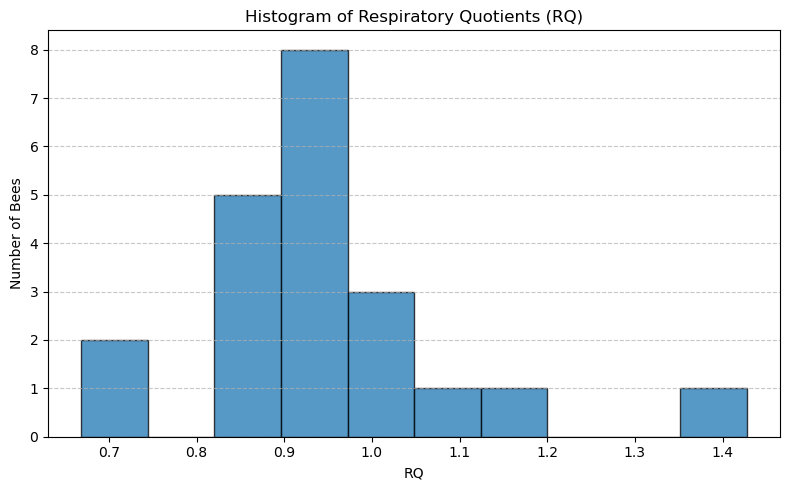

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(valid_rq, bins=10, edgecolor='black', alpha=0.75)
plt.title("Histogram of Respiratory Quotients (RQ)")
plt.xlabel("RQ")
plt.ylabel("Number of Bees")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
filtered_df.to_csv(r"C:\Users\labadmin\Documents\Uppsala analyses\filtered_bee_floral_metabolic_rates.csv", index=False)